In [1]:
# Name: probabilistic_comp_strawb.ipynb
# Authors: Stephan Meighen-Berger
# This is still in BETA!!!
# Comparison with STRAW-b data.
# Here we use the fact that the emissions seem to happen randomly and
# generate enough data to get every type of observed peak
# Note that here we are using the probabilistic model!
# To make a comparison large sets of data need to be generated.
# Running the data creation on a cluster is highly recommended!

In [2]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from scipy.signal import find_peaks
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
from scipy.optimize import curve_fit
from iminuit import Minuit
from scipy.special import gamma

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
def load_and_parse():
    """ Loads the generated probability grids and constructs a bivariate spline based on these
    
    Parameters
    ----------
    None

    Returns
    -------
    spl_prob : scipy.interpolate.RectBivariateSpline
        The RectBivariateSpline object containing the probabilties of emission based on position (x,y)
    """
    data_0 = pickle.load(open("probability_model/offcenter_v2_0.pkl", "rb"))
    data_1 = pickle.load(open("probability_model/offcenter_v2_1.pkl", "rb"))
    data_2 = pickle.load(open("probability_model/offcenter_v2_2.pkl", "rb"))
    data_3 = pickle.load(open("probability_model/offcenter_v2_3.pkl", "rb"))
    data_5 = pickle.load(open("probability_model/offcenter_v2_5.pkl", "rb"))
    id_alpha = 0
    counts_0, edges_0 = np.histogram(
        data_0['x_arr'][id_alpha],
        bins=np.linspace(0., 26., 131),
        weights=1./data_0['norm'][id_alpha]
    )
    counts_1, _ = np.histogram(
        data_1['x_arr'][id_alpha],
        bins=np.linspace(0., 26., 131),
        weights=1./data_1['norm'][id_alpha]
    )
    counts_2, _ = np.histogram(
        data_2['x_arr'][id_alpha],
        bins=np.linspace(0., 26., 131),
        weights=1./data_2['norm'][id_alpha]
    )
    counts_3, _ = np.histogram(
        data_3['x_arr'][id_alpha],
        bins=np.linspace(0., 26., 131),
        weights=1./data_3['norm'][id_alpha]
    )
    counts_5, _ = np.histogram(
        data_5['x_arr'][id_alpha],
        bins=np.linspace(0., 26., 131),
        weights=1./data_5['norm'][id_alpha]
    )
    spl_prob = RectBivariateSpline(
        (edges_0[1:] + edges_0[:-1]) / 2.,
        np.array([0., 1., 2., 3., 5.]),
        np.array([counts_0, counts_1,
                  counts_2, counts_3, counts_5]).T, s=0.4)
    return spl_prob

In [7]:
def constuct_sample_distro(mean: float, sd: float, distro_type: str, wavelengths: np.array,
                           emission_time=100., simulation_step=1.):
    """ Constructs a sample distribution (time-series) based on the mean, sd and distribution type
    
    Parameters
    ----------
    mean : float
        The distribution mean
    sd : float
        The distribution sd
    distro_type : str
        The distribution type
    wavelengths : np.array
        The wavelengths of interest
    emission_time : float
        OPTIONAL, the duration of light emission
    simulation_step : float
        OPTIONAL, steps to use in the time series

    Returns
    -------
    time_series : np.array
        The normalized time series for each wavelength

    Raises
    ------
    ValueError
        Unknown pdf distribution
    
    """
    # Constructing pdf
    if distro_type == "Gamma":
        distro = construct_pdf(
            {"class": "Gamma",
            "mean": mean,
            "sd": sd
            })
    elif distro_type == "Gauss":
        distro = construct_pdf(
            {"class": "Normal",
            "mean": mean,
            "sd": sd
            })
    else:
        raise ValueError("Unknown distribution type! Used: " + distro_type)
    # Normalizing the pdf
    norm_distro = (
        distro.pdf(np.arange(0., emission_time, simulation_step)) /
        np.trapz(distro.pdf(np.arange(0., emission_time, simulation_step)),
                 np.arange(0., emission_time, simulation_step))
    )
    # Constructing the wavelengths
    wave_pdf = construct_pdf(
        {"class": "Normal",
        "mean": 450.,
        "sd": 50.
        })
    # Normalizing according to the desired grid
    norm_wave = (
        wave_pdf.pdf(wavelengths) /
        np.trapz(wave_pdf.pdf(wavelengths), wavelengths)
    )
    # Constructing the time series depending on the wavelengths
    time_series = np.array([
        norm_distro * normalization
        for normalization in norm_wave
    ])
    return time_series

In [8]:
def peak_sample(xys: np.array, wavelengths: np.array, time_series: np.array):
    """ Samples the xys positions for the resulting measured peaks.
    
    Parameters
    ----------
    xys : np.array
        The x,y coordinates to sample (shape (n, 2))
    wavelengths : np.array
        The wavelengths of interest
    time_series : np.array
        The time series of emission (normalized) according to the wavelengths

    Returns
    -------
    sim_counts : np.array
        The resulting measurements for the xys
    """
    # --------------------------------------------------------------------
    #  Making some basic input checks
    # --------------------------------------------------------------------
    # Some basic settings for the run
    config['scenario']['class'] = 'Calibration'  # This should be a calibration run (pre-defined positions)
    config['scenario']['light prop'] = {  # Where the detector is located
                "switch": True,
                "x_pos": 5.,
                "y_pos": 10.,
            }
    config['scenario']['detector'] = {  # The detector to use (should be the PMT-spec from STRAW-b or its approximate)
        "switch": True,
        "type": "PMTSpec_Func",
        "response": True,
        "acceptance": "Flat",
        "mean detection prob": 1.
    }
    config['geometry']['detector properties']["PMTSpec_Func"] = {
        "x_pos": 2.,
        "y_pos": 5.,
        "det num": 12, #12 pmts numbered by position 
        "x_offsets": np.array(
            [0.1,0.,-0.1,0., 0.12,-0.12,-0.12,0.12, 0.2,-0.04,-0.2,0.04]
        ) / 2., #test radius 0.3 meter, real radius 0.15 meter
        "y_offsets": np.array(
            [0.,0.1,0.,-0.1,  0.12,0.12,-0.12,-0.12, 0.04,0.2,-0.04,-0.2]
        ) / 2.,
        "angle offset": np.array([
            90., 90., 90., 90., 90., 90.,
            90., 90., 90., 90., 90., 90.]),  # In which direction the detector(s) points
        "opening angle": np.array([
            25., 25., 25., 25., 25., 25.,
            25., 25., 25., 25., 25., 25.]),  # 25., # from dark box rotation test result: +-25 degrees
        "quantum efficiency": "Func",  # whether flat or function
        "wavelength acceptance": np.array([ #position number,center wavelength,quantum efficiency (if flat)
            [395., 405.],
            [505., 515.],
            [420., 430.],
            [465., 475.],
            [300., 600.],
            [487., 497.],
            [540., 560.],
            [515., 535.],
            [475., 485.],
            [445., 455.],
            [455., 465.],
            [325., 375.],                                     
        ]),
        "quantum func": np.array([
            [[395., 400., 405.], np.array([0.26, 0.26, 0.26])],
            [[505., 510., 515.], np.array([0.16, 0.16, 0.16])],
            [[420., 425., 430.], np.array([0.28, 0.28, 0.28])],
            [[465., 470., 475.], np.array([0.23, 0.23, 0.23])],
            [[300., 500., 600.], np.array([1., 1., 1.])],
            [[487., 490., 497.], np.array([0.1, 0.1, 0.1])],
            [[540., 550., 560.], np.array([0.1, 0.1, 0.1])],
            [[515., 525., 535.], np.array([0.13, 0.13, 0.13])],
            [[475., 480., 485.], np.array([0.2, 0.2, 0.2])],
            [[445., 450., 455.], np.array([0.2, 0.2, 0.2])],
            [[455., 460., 465.], np.array([0.23, 0.23, 0.23])],
            [[325., 350., 375.], np.array([0.3, 0.3, 0.3])],
        ])
    }
    # The injected pulse
    injection_pulse = {}
    for id_wave, wavelength in enumerate(wavelengths):
        injection_pulse[wavelength] = time_series[id_wave]
    config['calibration']['light curve'] = injection_pulse
    sim_counts = []
    # Starting the loop over the positions
    for xy in tqdm(xys):
        # The flasher position
        config['calibration']['pos_arr'] = xy
        # Creating a fourth_day object
        fd = Fourth_Day()
        # Launching solver
        fd.sim()
        sim_counts.append(fd.measured)
    return sim_counts

In [9]:
# Parameters
wavelengths = np.linspace(300., 600., 61)
dx2, dy2 = 1., 1.
x2 = np.arange(0., 3., dx2)
y2 = np.arange(0., 26., dy2)
mesh = np.array(np.meshgrid(x2, y2))
combinations = mesh.T.reshape(-1, 2)
# X2, Y2 = np.meshgrid(x2,y2)
# Z2 = spl_prob(y2, x2)
# Z2[Z2 < 0.] = 0.

In [10]:
# Constructing the probabilities of emission
prob_spline = load_and_parse()
# Constructing the emission time series
time_series_1 = constuct_sample_distro(2., 1.5, "Gamma", wavelengths,
                                       emission_time=100., simulation_step=1.)
time_series_2 = constuct_sample_distro(2., 0.3, "Gamma", wavelengths,
                                       emission_time=100., simulation_step=1.)

In [11]:
# Running the peak sampler
constructed_peak_samples_1 = peak_sample(combinations, wavelengths, time_series_1)
constructed_peak_samples_2 = peak_sample(combinations, wavelengths, time_series_2)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:42<00:00,  1.31s/it]


In [12]:
# Plotting standards
std_size = 10.  # The plot size
fontsize = 20.
lw=1.
h_length=1.

In [13]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [14]:
# Function used to smooth the plots
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [15]:
# Fetching data
PMT_measurements = np.loadtxt('../data/detector/STRAW-B/PMT_Total.txt',delimiter=',')
PMT_sorted = PMT_measurements[PMT_measurements[:, 0].argsort()]

In [16]:
xdat = (PMT_sorted[:, 0][:380] - 30.)
ydat = smooth(np.log10(PMT_sorted[:, 1][:380]) - 0., 1)
ydat[ydat < 0.] = 0.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


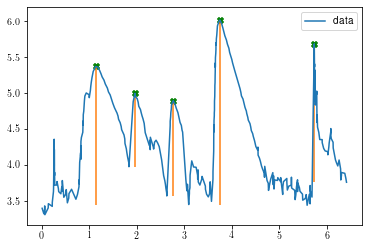

In [17]:
# Data
plt.plot(xdat, ydat, label='data')
# Peaks
peaks, properties = find_peaks(ydat, height=0, width=10)
plt.scatter(xdat[peaks], ydat[peaks], marker='X', color='g')
plt.vlines(x=xdat[peaks], ymin=ydat[peaks] - properties["prominences"],
           ymax = ydat[peaks], color = "C1")
plt.legend(loc='upper right')
# plt.xlim(0., 1)
plt.show()

In [18]:
def func(x, *params):
    y = np.zeros_like(x)
    pars = params[0]
    for i in range(0, len(pars), 4):
        amp = pars[i]
        shift = pars[i+1]
        mean = pars[i+2]
        sd = pars[i+3]
        distro = construct_pdf(
            {"class": "Gamma",
             "mean": mean,
             "sd": sd
            })
        x_fit_arr = np.arange(0., 10., 0.1)
        norm_distro = (
            distro.pdf(x_fit_arr) /
            np.trapz(distro.pdf(x_fit_arr),
                     x_fit_arr)
        )
        distro_spl = UnivariateSpline(x_fit_arr + np.nan_to_num(shift), norm_distro * amp, k=1, ext=1, s=0)
        y = y + distro_spl(x)
    return np.nan_to_num(y) + min(ydat[peaks] - properties["prominences"])
sigma_y = np.sqrt(ydat)
def LSQ(params):
    ym = func(xdat, params)
    unsummed = ((ydat - ym) ** 2 / sigma_y ** 2)
    res = np.sum(unsummed)
    return res
guess = []
for i in range(len(peaks)):
    guess += [properties["prominences"][i], xdat[peaks][i], 0.5, 0.2]
m = Minuit(LSQ, guess)
for i in range(0, len(guess), 4):
    m.limits[i] = (0., 10.)
    m.limits[i+2] = (0.5, 10.)
    m.limits[i+3] = (0.5, 10.)
# Make sure shifts are at the desired positions
for i in range(0, len(peaks)):
    m.limits[i+1] = (xdat[peaks][i] * 0.9, xdat[peaks][i] * 1.1)
m.migrad()

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:40: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 36.38                      │             Nfcn = 4122              │
│ EDM = 57.9 (Goal: 0.0002)        │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │     6     │            │            │    0    │   10    │       │
│ 1 │ x1   │   1.14    │   0.17    │            │            │ 1.01909 │ 1.24555 │       │
│ 2 │ x2   │   1.76    │   0.31    │            │            │ 1.76394 │ 2.15592 │       │
│ 3 │ x3   │    2.5    │    0.4    │            │            │ 2.48798 │ 3.04086 │       │
│ 4 │ x4   │    3.4    │    0.7    │            │            │ 3.3723  │ 4.1217  │       │
│ 5 │ x5   │    5.4    │    0.7    │            │            │ 5.15843 │ 6.30475 │       │
│ 6 │ x6   │     2     │     6     │            │            │   0.5   │   10    │       │
│ 7 │ x7   │     1     │     5     │            │            │   0.5   │   10    │       │
│ 8 │ x8   │     1     │     6     │            │            │    0    │   10    │       │
│ 9 │ x9   │    2.8    │    1.0    │            │            │         │         │       │
│ 10│ x10  │     1     │     5     │            │            │   0.5   │   10    │       │
│ 11│ x11  │     1     │     6     │            │            │   0.5   │   10    │       │
│ 12│ x12  │     1     │     5     │            │            │    0    │   10    │       │
│ 13│ x13  │    3.6    │    1.0    │            │            │         │         │       │
│ 14│ x14  │     1     │     5     │            │            │   0.5   │   10    │       │
│ 15│ x15  │     1     │     5     │            │            │   0.5   │   10    │       │
│ 16│ x16  │     0     │     6     │            │            │    0    │   10    │       │
│ 17│ x17  │    5.7    │    1.0    │            │            │         │         │       │
│ 18│ x18  │     1     │     7     │            │            │   0.5   │   10    │       │
│ 19│ x19  │     1     │     7     │            │            │   0.5   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14       x15       x16       x17       x18       x19 │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      2.03  0.000228         0         0 -0.000199  0.000718   0.00636   0.00231   0.00279 -0.000171  -0.00709 -3.99e-08    0.0219  -0.00266  7.77e-09  5.84e-09 -0.000744 -0.000114  5.68e-10   5.7e-10 │
│  x1 │  0.000228    0.0142         0         0 -2.15e-05  -0.00014  -0.00026  0.000179  -0.00112  1.19e-05  0.000948  -1.4e-08 -0.000903  0.000136 -8.22e-10 -6.18e-10   1.5e-05  7.78e-06  1.25e-11  1.72e-11 │
│  x2 

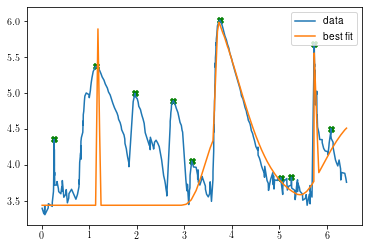

In [19]:
plt.plot(xdat, ydat, label='data')
plt.plot(xdat, func(xdat, m.values), label='best fit')
# Peaks
peaks, _ = find_peaks(ydat, height=0, width=3)
plt.scatter(xdat[peaks], ydat[peaks], marker='X', color='g')
plt.legend(loc='upper right')
# plt.ylim(0., 3)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


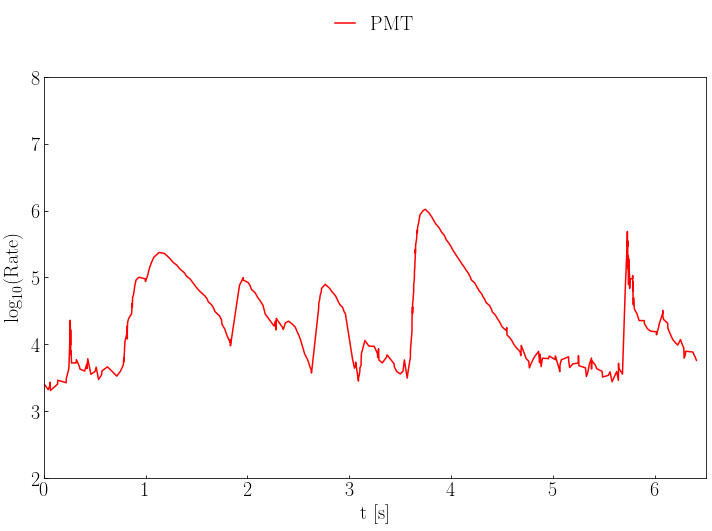

In [20]:
data_smoothing = 1
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# Data
ax1.plot(xdat, ydat,
         color='r', label=r'$\mathrm{PMT}$')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\log_{10}(\mathrm{Rate})$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(2, 8.)
ax1.set_xlim(0., 6.5)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "Strawb_Combined.png",
               bbox_inches='tight')